## 第9章 潜在顧客を把握するための画像処理10本ノック

この記事は[「Python実践データ分析100本ノック」](https://www.amazon.co.jp/dp/B07ZSGSN9S/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1)の演習を実際にやってみたという内容になっています。今まで自己流でやってきましたが、一度他の方々がどのような考え方やコーディングをしているのか勉強してみようと思ってやってみました。本書は実際の業務に活用する上でとても参考になる内容だと思っています。データ分析に関わる仕事をしたい方にお勧めしたいです。

私は画像やテキストの処理は割と経験あるので、前章のネットワークの可視化などよりかなりスムーズに演習することが出来ました。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/ml/data100/09/09_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/ml/data100/09/09_nb.ipynb)

### 筆者の環境

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6020


In [2]:
!python -V

Python 3.7.3


基本的なライブラリをインポートしそのバージョンを確認しておきます。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('pandas version :', pd.__version__)

matplotlib version : 3.0.3
scipy version : 1.4.1
numpy version : 1.16.2
pandas version : 1.0.3


## 解答

### ノック 81 : 画像データを読み込んでみよう 

画像幅 :  1920
画像の高さ :  1440


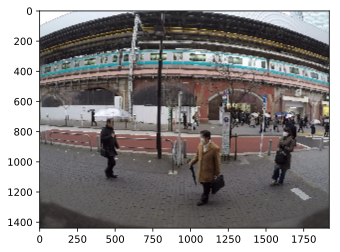

In [4]:
import cv2
import os

img = cv2.imread('img/img01.jpg')

if os.path.isfile('img/img01.jpg'):
  height, width = img.shape[:2]

print('画像幅 : ', width)
print('画像の高さ : ', height)

#画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### ノック 82 : 映像データを読み込んでみよう

映像の取得のため、VideoCapture関数を利用します。取得した映像情報をcapに格納し、getにより情報を取得します。フレーム毎の情報をreadメソッドで読み出します。これにより動画情報を画像情報と同様に操作し、imshowメソッドで表示可能です。

In [ ]:
cap = cv2.VideoCapture('mov/mov01.avi')
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)

while(cap.isOpened()):
  ret, frame = cap.read()
  if ret:
    cv2.imshow('frame', frame)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

### ノック 83 : 映像を画像に分割し、保存してみよう

スナップショットとして画像として保存します。

In [ ]:
cap = cv2.VideoCapture('mov/mov01.avi')

num = 0
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret:
    filepath = 'snapshot/snapshot_' + str(num) + '.jpg'
    cv2.imwrite(filepath, frame) 
    num += 1
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  
cap.release()
cv2.destroyAllWindows()

In [ ]:
!ls snapshot/

### ノック 84 : 画像内のどこに人がいるのか検出しよう

HOG抽出量により人の認識を行います。HOG特徴量というのは「Histogram of Oriented Gradients」の略で、輝度勾配と言います。

In [7]:
# 準備 #
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold':0, 'finalThreshold':5}

# 検出 #
img = cv2.imread("img/img01.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
human, r = hog.detectMultiScale(gray, **hogParams)

# 人の認識部分を白線で囲みます
if (len(human)>0):
  for (x, y, w, h) in human:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255,255,255), 3)

    cv2.imshow("img",img)

cv2.imwrite("temp.jpg",img)

True

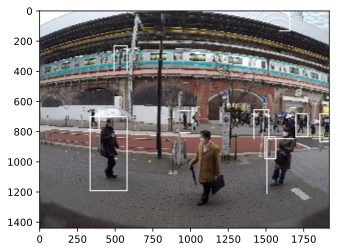

In [9]:
#画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

少々誤認識もありますが、人の姿を捉えている様子がわかります。

### ノック 85 : 画像内の人の顔を検出してみよう

OpenCVで人の顔を検出するには"haarcascade_frontalface_alt.xml"という顔認識用のモデルファイルを読み込みます。OpenCVには顔以外にも鼻や口などを認識するためのモデルもあります。

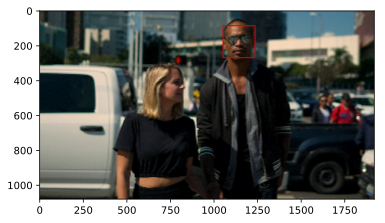

In [11]:
# 準備
cascade_file = "haarcascade_frontalface_alt.xml"
cascade = cv2.CascadeClassifier(cascade_file)

# 検出
img = cv2.imread("img/img02.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_list = cascade.detectMultiScale(gray, minSize=(50, 50))

# 検出した顔に印を付ける
for (x, y, w, h) in face_list:
  color = (0, 0, 225)
  pen_w = 3
  cv2.rectangle(img, (x, y), (x+w, y+h), color, thickness = pen_w)

cv2.imwrite("temp.jpg",img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### ノック 86 : 画像内の人がどこに顔を向けているのかを検出してみよう

dlibというライブラリを利用して、表情の特徴を捉えることも出来ます。dlibのshape_predictorによって、68点の顔のモデルを読み込みます。そこからget_frontal_face_detectorによって

In [12]:
import dlib
import math

# 準備 #
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

ModuleNotFoundError: No module named 'dlib'

In [ ]:
# 検出 #
img = cv2.imread("img/img02.jpg")
dets = detector(img, 1)

for k, d in enumerate(dets):
  shape = predictor(img, d)

  # 顔領域の表示
  color_f = (0, 0, 225)
  color_l_out = (255, 0, 0)
  color_l_in = (0, 255, 0)
  line_w = 3
  circle_r = 3
  fontType = cv2.FONT_HERSHEY_SIMPLEX
  fontSize = 1
  cv2.rectangle(img, (d.left(), d.top()), (d.right(), d.bottom()), color_f, line_w)
  cv2.putText(img, str(k), (d.left(), d.top()), fontType, fontSize, color_f, line_w)

  # 重心を導出する箱を用意
  num_of_points_out = 17
  num_of_points_in = shape.num_parts - num_of_points_out
  gx_out = 0
  gy_out = 0
  gx_in = 0
  gy_in = 0
  for shape_point_count in range(shape.num_parts):
    shape_point = shape.part(shape_point_count)
    #print("顔器官No.{} 座標位置: ({},{})".format(shape_point_count, shape_point.x, shape_point.y))
    #器官ごとに描画
    if shape_point_count<num_of_points_out:
      cv2.circle(img,(shape_point.x, shape_point.y),circle_r,color_l_out, line_w)
      gx_out = gx_out + shape_point.x/num_of_points_out
      gy_out = gy_out + shape_point.y/num_of_points_out
    else:
      cv2.circle(img,(shape_point.x, shape_point.y),circle_r,color_l_in, line_w)
      gx_in = gx_in + shape_point.x/num_of_points_in
      gy_in = gy_in + shape_point.y/num_of_points_in

  # 重心位置を描画
  cv2.circle(img,(int(gx_out), int(gy_out)),circle_r,(0,0,255), line_w)
  cv2.circle(img,(int(gx_in), int(gy_in)),circle_r,(0,0,0), line_w)

  # 顔の方位を計算
  theta = math.asin(2*(gx_in-gx_out)/(d.right()-d.left()))
  radian = theta*180/math.pi
  print("顔方位:{} (角度:{}度)".format(theta,radian))

  # 顔方位を表示
  if radian<0:
    textPrefix = "   left "
  else:
    textPrefix = "   right "
  textShow = textPrefix + str(round(abs(radian),1)) + " deg."
  cv2.putText(img, textShow, (d.left(), d.top()), fontType, fontSize, color_f, line_w)

In [ ]:
cv2.imwrite("temp.jpg",img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### ノック 87 : 検出した情報を統合し、タイムラプスを作ってみよう

数フレームから1フレームを抽出したタイムラプスを作ります。

In [ ]:
print("タイムラプス生成を開始します")

# 映像取得 #
cap = cv2.VideoCapture("mov/mov01.avi")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [ ]:
# hog宣言 #
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold':0, 'finalThreshold':5}

In [ ]:
# タイムラプス作成 #
movie_name = "timelapse.avi"
fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
video = cv2.VideoWriter(movie_name,fourcc, 30, (width,height))

num = 0
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret:
    if (num%10==0):
      gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      human, r = hog.detectMultiScale(gray, **hogParams)
      if (len(human)>0):
        for (x, y, w, h) in human:
          cv2.rectangle(frame, (x, y), (x + w, y + h), (255,255,255), 3)

      video.write(frame)
  else:
    break
  num = num + 1
video.release()
cap.release()
# cv2.destroyAllWindows()
print("タイムラプス生成を終了しました")

### ノック 88 : 全体像をグラフにして可視化してみよう

In [ ]:
import pandas as pd

print("分析を開始します")
# 映像取得 #
cap = cv2.VideoCapture("mov/mov01.avi")
fps = cap.get(cv2.CAP_PROP_FPS)

In [ ]:
# hog宣言 #
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold':0, 'finalThreshold':5}

In [ ]:
num = 0
list_df = pd.DataFrame( columns=['time','people'] )
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret:
    if (num%10==0):
      gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      human, r = hog.detectMultiScale(gray, **hogParams)
      if (len(human)>0):
        for (x, y, w, h) in human:
          cv2.rectangle(frame, (x, y), (x + w, y + h), (255,255,255), 3)
      tmp_se = pd.Series( [num/fps,len(human) ], index=list_df.columns )
      list_df = list_df.append( tmp_se, ignore_index=True )     
      if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  else:
    break
  num = num + 1
  
cap.release()
cv2.destroyAllWindows()
print("分析を終了しました")

グラフにして可視化します。

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_df["time"], list_df["people"])
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.show()

### ノック 89 : 人通りの変化をグラフで確認しよう

In [ ]:
print("分析を開始します")
# 映像取得 #
cap = cv2.VideoCapture("mov/mov02.avi")
fps = cap.get(cv2.CAP_PROP_FPS)

# hog宣言 #
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {'winStride': (8, 8), 'padding': (32, 32), 'scale': 1.05, 'hitThreshold':0, 'finalThreshold':5}

num = 0
list_df2 = pd.DataFrame( columns=['time','people'] )
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret:
    if (num%10==0):
      gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      human, r = hog.detectMultiScale(gray, **hogParams)
      if (len(human)>0):
        for (x, y, w, h) in human:
          cv2.rectangle(frame, (x, y), (x + w, y + h), (255,255,255), 3)
      tmp_se = pd.Series( [num/fps,len(human) ], index=list_df.columns )
      list_df2 = list_df2.append( tmp_se, ignore_index=True )     
      if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  else:
    break
  num = num + 1
cap.release()
cv2.destroyAllWindows()
print("分析を終了しました")

人の人数をグラフで可視化します。

In [ ]:
plt.plot(list_df2["time"], list_df2["people"])
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.show()

### ノック 90 : 移動平均を計算することでノイズの影響を除去しよう 

移動平均を計算し、同じグラフに描画することでノイズを低減させます。

In [ ]:
def moving_average(x, y):
  y_conv = np.convolve(y, np.ones(5)/float(5), mode='valid')
  x_dat = np.linspace(np.min(x), np.max(x), np.size(y_conv))
  return x_dat, y_conv

In [ ]:
plt.plot(list_df["time"], list_df["people"], label="raw")
ma_x, ma_y = moving_average(list_df["time"], list_df["people"])
plt.plot(ma_x,ma_y, label="average")
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.legend()
plt.show()

In [ ]:
plt.plot(list_df2["time"], list_df2["people"], label="raw")
ma_x2, ma_y2 = moving_average(list_df2["time"], list_df2["people"])
plt.plot(ma_x2,ma_y2, label="average")
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.legend()
plt.show()

In [ ]:
plt.plot(ma_x,ma_y, label="1st")
plt.plot(ma_x2,ma_y2, label="2nd")
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,15)
plt.legend()
plt.show()

## 関連記事
- [第1章 ウェブからの注文数を分析する10本ノック](/ml/data100/01/)
- [第2章 小売店のデータでデータ加工を行う10本ノック](/ml/data100/02/)
- [第3章 顧客の全体像を把握する10本ノック](/ml/data100/03/)
- [第4章 顧客の行動を予測する10本ノック](/ml/data100/04/)
- [第5章 顧客の退会を予測する10本ノック](/ml/data100/05/)
- [第6章 物流の最適ルートをコンサルティングする10本ノック](/ml/data100/06/)
- [第7章 ロジスティクスネットワークの最適設計を行う10本ノック](/ml/data100/07/)
- [第8章 数値シミュレーションで消費者行動を予測する10本ノック](/ml/data100/08/)
- [第9章 潜在顧客を把握するための画像認識10本ノック](/ml/data100/09/)
- [第10章 アンケート分析を行うための自然言語処理10本ノック](/ml/data100/10/)